## Predicting hand written digits between 0 and 9 using the full MNIST Dataset

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 12.7 MB/s 
     |████████████████████████████████| 1.2 MB 33.3 MB/s 
     |████████████████████████████████| 46 kB 2.9 MB/s 
     |████████████████████████████████| 186 kB 46.6 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 348 kB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST)
print(path)
Path.BASE_PATH = path

path

/root/.fastai/data/mnist_png


Path('.')

In [4]:
# examine all of the paths required
all_paths = (path/'training').ls()
all_paths

(#10) [Path('training/9'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/1'),Path('training/5'),Path('training/8'),Path('training/0'),Path('training/7'),Path('training/6')]

In [5]:
validation_paths = (path/'testing').ls()
validation_paths

(#10) [Path('testing/9'),Path('testing/2'),Path('testing/3'),Path('testing/4'),Path('testing/1'),Path('testing/5'),Path('testing/8'),Path('testing/0'),Path('testing/7'),Path('testing/6')]

In [6]:
get_tensors_from_path = lambda num, set_type: torch.stack([tensor(Image.open(file_url)) for file_url in (path/set_type/num).ls()]).float()/255

In [7]:
ones = get_tensors_from_path('1', 'training')
ones.shape

torch.Size([6742, 28, 28])

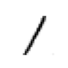

In [8]:
show_image(ones[0])

In [9]:
numbers = [str(i) for i in range(10)]
all_train_list = [get_tensors_from_path(number, 'training') for number in numbers]
all_valid_list = [get_tensors_from_path(number, 'testing') for number in numbers]

In [10]:
len(all_train_list), all_train_list[0].shape, all_train_list[1].shape

(10, torch.Size([5923, 28, 28]), torch.Size([6742, 28, 28]))

In [11]:
len(all_valid_list), all_valid_list[0].shape, all_valid_list[1].shape

(10, torch.Size([980, 28, 28]), torch.Size([1135, 28, 28]))

In [12]:
num_element_list = []
num_valid_elements = []
# test getting the number of each type of image in the training list
for i in range (len(all_train_list)):
  print("Num elements for", i, "is", all_train_list[i].shape[0])
  num_element_list.append(all_train_list[i].shape[0])
  num_valid_elements.append(all_valid_list[i].shape[0])

num_element_list, num_valid_elements

Num elements for 0 is 5923
Num elements for 1 is 6742
Num elements for 2 is 5958
Num elements for 3 is 6131
Num elements for 4 is 5842
Num elements for 5 is 5421
Num elements for 6 is 5918
Num elements for 7 is 6265
Num elements for 8 is 5851
Num elements for 9 is 5949


([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
 [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009])

In [13]:
# create the training and validation sets
# reduce to 2D matrix 784 columns (one row per image)
train_x = torch.cat(all_train_list).view(-1, 28*28)

# make a list of tensors of corresponding target values, then concatenate tensors using unsqueeze
train_y = torch.cat([tensor([i]*num_element_list[i]) for i in range(len(num_element_list))]).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [14]:
# do the same for validaiton set
valid_x = torch.cat(all_valid_list).view(-1, 28*28)
valid_y = torch.cat([tensor([i]*num_valid_elements[i]) for i in range(len(num_valid_elements))]).unsqueeze(1)
valid_x.shape, valid_y.shape


(torch.Size([10000, 784]), torch.Size([10000, 1]))

(<matplotlib.image.AxesImage at 0x7f022160aa50>, tensor([0]))

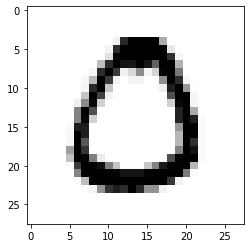

In [15]:
plt.imshow(train_x[0].view(28, 28)), train_y[0]

(<matplotlib.image.AxesImage at 0x7f022160afd0>, tensor([0]))

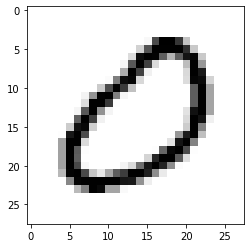

In [16]:
plt.imshow(train_x[1000].view(28, 28)), train_y[1000]

(<matplotlib.image.AxesImage at 0x7f021e700590>, tensor([1]))

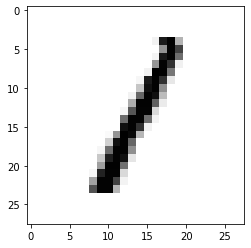

In [17]:
plt.imshow(train_x[10000].view(28, 28)), train_y[10000]

(<matplotlib.image.AxesImage at 0x7f02220fdcd0>, tensor([8]))

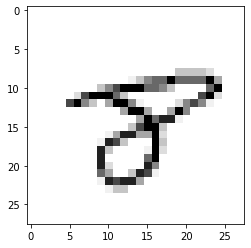

In [18]:
plt.imshow(train_x[50000].view(28, 28)), train_y[50000]

In [19]:
# the images seem correctly labelled, create two data loaders now - for training and validation sets
to_loader = lambda x, y, batch_size: DataLoader(list(zip(x, y)), batch_size=batch_size)

train_dl = to_loader(train_x, train_y, 256)
valid_dl = to_loader(valid_x, valid_y, 256)
first(train_dl)[0].shape, first(train_dl)[1].shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [20]:
# combine both into a single dataloaders
dls = DataLoaders(train_dl, valid_dl)

In [21]:
# make some sample lists to test new lost function
sample_acts = torch.randn(size=(4, 10))*3
sample_targ = torch.tensor([5, 8, 2, 4])
sample_acts, sample_targ

(tensor([[ 2.0353, -3.7036, -0.1292, -4.8140,  5.3634, -1.4341, -0.7286, -2.8025, -2.1836, -1.6783],
         [-2.3065,  2.2873, -4.7020, -0.7183,  6.9684, -2.8901, -2.2744,  3.2350,  2.4024,  5.0419],
         [ 1.0676, -2.0599, -1.4801,  0.7245,  3.9369,  2.0615, -3.2675, -1.0659, -2.7415, -1.9744],
         [ 0.2341,  1.5774,  3.5369, -1.3034, -4.1591, -3.8586, -4.2097,  0.1080, -0.1904,  2.0268]]),
 tensor([5, 8, 2, 4]))

In [108]:
# create some loss function to deal with 10 entries
def ce_loss(acts, targets, softmax=True):
  if not softmax:
    smax = torch.softmax(acts, dim=1)
  else:
    smax = acts
  s_log = smax.log()
  nll_loss = -s_log[range(acts.shape[0]), targets]
  return nll_loss.mean()

In [109]:
ce_loss(sample_acts, sample_targ, softmax=False), nn.CrossEntropyLoss()(sample_acts, sample_targ)

(tensor(6.3285), tensor(6.3285))

In [110]:
# create optimizer
class SGDOpt:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr

  def update_lr(self, new_lr):
    self.lr = new_lr
  
  def step(self):
    for param in self.params:
      param.data -= param.grad * self.lr

  def zero_grad(self):
    for param in self.params:
      param.grad = None

In [111]:
# create a metric function
def epoch_acc(valid_dl, model):

  def batch_acc(batch_x, batch_y):
    preds = model(batch_x).argmax(dim=-1)
    return (preds == batch_y).float().mean()

  accs = [batch_acc(x, y) for x, y in valid_dl]
  return torch.stack(accs).mean()


In [112]:
# create the model
mnist_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),

    nn.Linear(30, 20),
    nn.ReLU(),

    nn.Linear(20, 10),
    nn.Softmax()
)

mnist_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=10, bias=True)
  (5): Softmax(dim=None)
)

In [142]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10),
    nn.Softmax()
)
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=10, bias=True)
  (3): Softmax(dim=None)
)

In [113]:
mnist_net(first(dls.train)[0])[10]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.0943, 0.0806, 0.0926, 0.1214, 0.1238, 0.1050, 0.1185, 0.1003, 0.0734, 0.0900], grad_fn=<SelectBackward>)

In [143]:
def train_model(model, epochs, loss_func, opt, metric_func, dls, lr):
  optimizer = opt(model.parameters(), lr)
  # print(optimizer.params[0].shape)
  # train for the required number of epochs
  for i in range(epochs):
    # train for each minibatch
    for tr_x, tr_y in dls.train:
      # plt.imshow(tr_x[0].view(28, 28))
      preds = model(tr_x)
      # print(preds[0], tr_y[0])
      # print(tr_y.shape)
      loss = loss_func(preds, tr_y)
      # print(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
  
    # once an epoch is complete, get metric
    acc = epoch_acc(dls.valid, model)
    print(f"Epoch {i+1} has accuracy: {acc}")

In [144]:
train_model(simple_net, 100, ce_loss, SGDOpt, epoch_acc, dls, 0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1 has accuracy: 0.14329680800437927
Epoch 2 has accuracy: 0.23804131150245667
Epoch 3 has accuracy: 0.3411697447299957
Epoch 4 has accuracy: 0.4099845886230469
Epoch 5 has accuracy: 0.45345228910446167
Epoch 6 has accuracy: 0.4826454222202301
Epoch 7 has accuracy: 0.5021457672119141
Epoch 8 has accuracy: 0.5213238000869751
Epoch 9 has accuracy: 0.54107666015625
Epoch 10 has accuracy: 0.5764236450195312
Epoch 11 has accuracy: 0.6159431338310242
Epoch 12 has accuracy: 0.6465843319892883
Epoch 13 has accuracy: 0.6714847683906555
Epoch 14 has accuracy: 0.687696099281311
Epoch 15 has accuracy: 0.6988372802734375
Epoch 16 has accuracy: 0.7052993774414062
Epoch 17 has accuracy: 0.7116691470146179
Epoch 18 has accuracy: 0.7124443054199219
Epoch 19 has accuracy: 0.7131736874580383
Epoch 20 has accuracy: 0.7150127291679382
Epoch 21 has accuracy: 0.7167320251464844
Epoch 22 has accuracy: 0.7203003168106079
Epoch 23 has accuracy: 0.7245586514472961
Epoch 24 has accuracy: 0.7259639501571655
E

In [132]:
model(first(dls.valid)[0])[10], first(dls.valid)[1][0]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], grad_fn=<SelectBackward>),
 tensor([0]))

In [290]:
list(dls.valid)[10][1][0]

tensor([2])

(<matplotlib.image.AxesImage at 0x7f0220f3acd0>, tensor([0]))

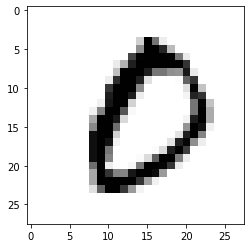

In [283]:
valid_dl = list(dls.valid)
x_0 = valid_dl[0][0][0]
y_0 = valid_dl[0][1][0]
plt.imshow(x_0.view(28, 28)), y_0

In [157]:
# see if the model predicts 0
simple_net(x_0).argmax()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0)

In [193]:
# os.chdir('C:/Users')
path = Path('/content')
im_paths = (path/'sample_data'/'mnist_test').ls()

In [194]:
im_1 = im_paths[0]
im_1

Path('/content/sample_data/mnist_test/20210823_151934.jpg')

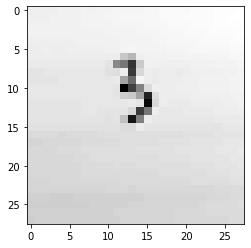

In [239]:

img =  255-tensor(Image.open(im_paths[0]).convert('L').resize((28, 28)))
plt.imshow(img)

In [240]:
get_tensors_from_path_list = lambda path_list: torch.stack([255-tensor(Image.open(file_url).resize((28, 28)).convert('L')) for file_url in path_list]).float()/255

im_tens = get_tensors_from_path_list(im_paths)
im_tens.shape

torch.Size([7, 28, 28])

In [255]:
torch.all(im_tens[0] == img.float()/255)

tensor(False)

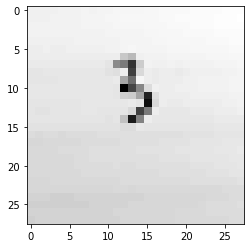

In [258]:
plt.imshow(im_tens[0])

In [259]:
simple_net(im_tens[0].view(-1, 28*28)).argmax()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(8)

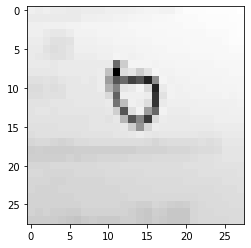

In [260]:
plt.imshow(im_tens[1])

In [261]:
simple_net(im_tens[1].view(-1, 28*28)).argmax()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(8)

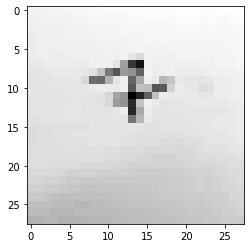

In [262]:
plt.imshow(im_tens[2])

In [263]:
simple_net(im_tens[2].view(-1, 28*28)).argmax()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(8)

In [264]:
for i in range(7):
  print(simple_net(im_tens[i].view(-1, 28*28)).argmax())

tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [291]:
x_1 = valid_dl[10][0][0]
y_1 = valid_dl[10][1][0]
x_1.shape, y_1.shape

(torch.Size([784]), torch.Size([1]))

(<matplotlib.image.AxesImage at 0x7f0220f51c90>, tensor([2]))

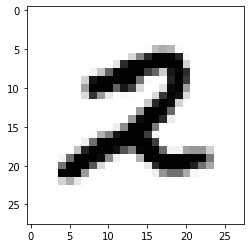

In [292]:
plt.imshow(x_1.view(28, 28)), y_1

In [293]:
# see if the model predicts 2
simple_net(x_1).argmax()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(2)

(<matplotlib.image.AxesImage at 0x7f0220f27310>, tensor([3]))

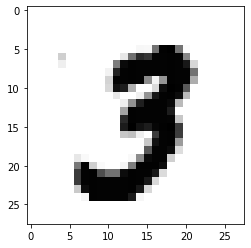

In [294]:
x_2 = valid_dl[15][0][0]
y_2 = valid_dl[15][1][0]
plt.imshow(x_2.view(28, 28)), y_2

In [295]:
# see if the model predicts 2
simple_net(x_2).argmax()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(3)